In [1]:
print("""
Riker Wachtler
22 October 2023
Wine Classification Midterm Project""")


Riker Wachtler
22 October 2023
Wine Classification Midterm Project


In [2]:
import os, shutil

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

import keras, keras_tuner as kt, tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.initializers import TruncatedNormal 
from keras.utils import to_categorical
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
from sklearn import datasets

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")

Using TensorFlow backend


In [3]:
print("""
This is a classification attempt on a very unoriginal dataset (for the midterm, I mean), the wine dataset from UCI, used via the sklearn databases.

The data is composed of 13 features; Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, and Proline. They are not measured on any uniform scale. The samples are in 3 classes, so this is a classification problem on those features. It has no missing values and has been cleaned up already.

I used a very simple ANN with one hidden layer, and used hyperparameter tuning to decide the number of nodes in that layer. The input layer was obviously based on the input dimension & the output the number of classes, so they were not tuned. I used a Hyperband tuner to do this, with the normal epoch/factor of 100/3. After that search, I fit the model on the training data (randomly selected as 75% of the dataset) over 300 epochs, validated with the remaining 25% test data from the dataset, and then plotted the accuracy/loss & confusion matrix. """)


This is a classification attempt on a very unoriginal dataset (for the midterm, I mean), the wine dataset from UCI, used via the sklearn databases.

The data is composed of 13 features; Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, and Proline. They are not measured on any uniform scale. The samples are in 3 classes, so this is a classification problem on those features. It has no missing values and has been cleaned up already.

I used a very simple ANN with one hidden layer, and used hyperparameter tuning to decide the number of nodes in that layer. The input layer was obviously based on the input dimension & the output the number of classes, so they were not tuned. I used a Hyperband tuner to do this, with the normal epoch/factor of 100/3. After that search, I fit the model on the training data (randomly selected as 75% of the dataset) over 300 epochs, vali

In [4]:
# fetch dataset
wine = datasets.load_wine()

df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['label'] = wine.target

In [5]:
# split dataset into train/test, proportioned at 25%
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.25)

# convert y_train & y_test to categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [7]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


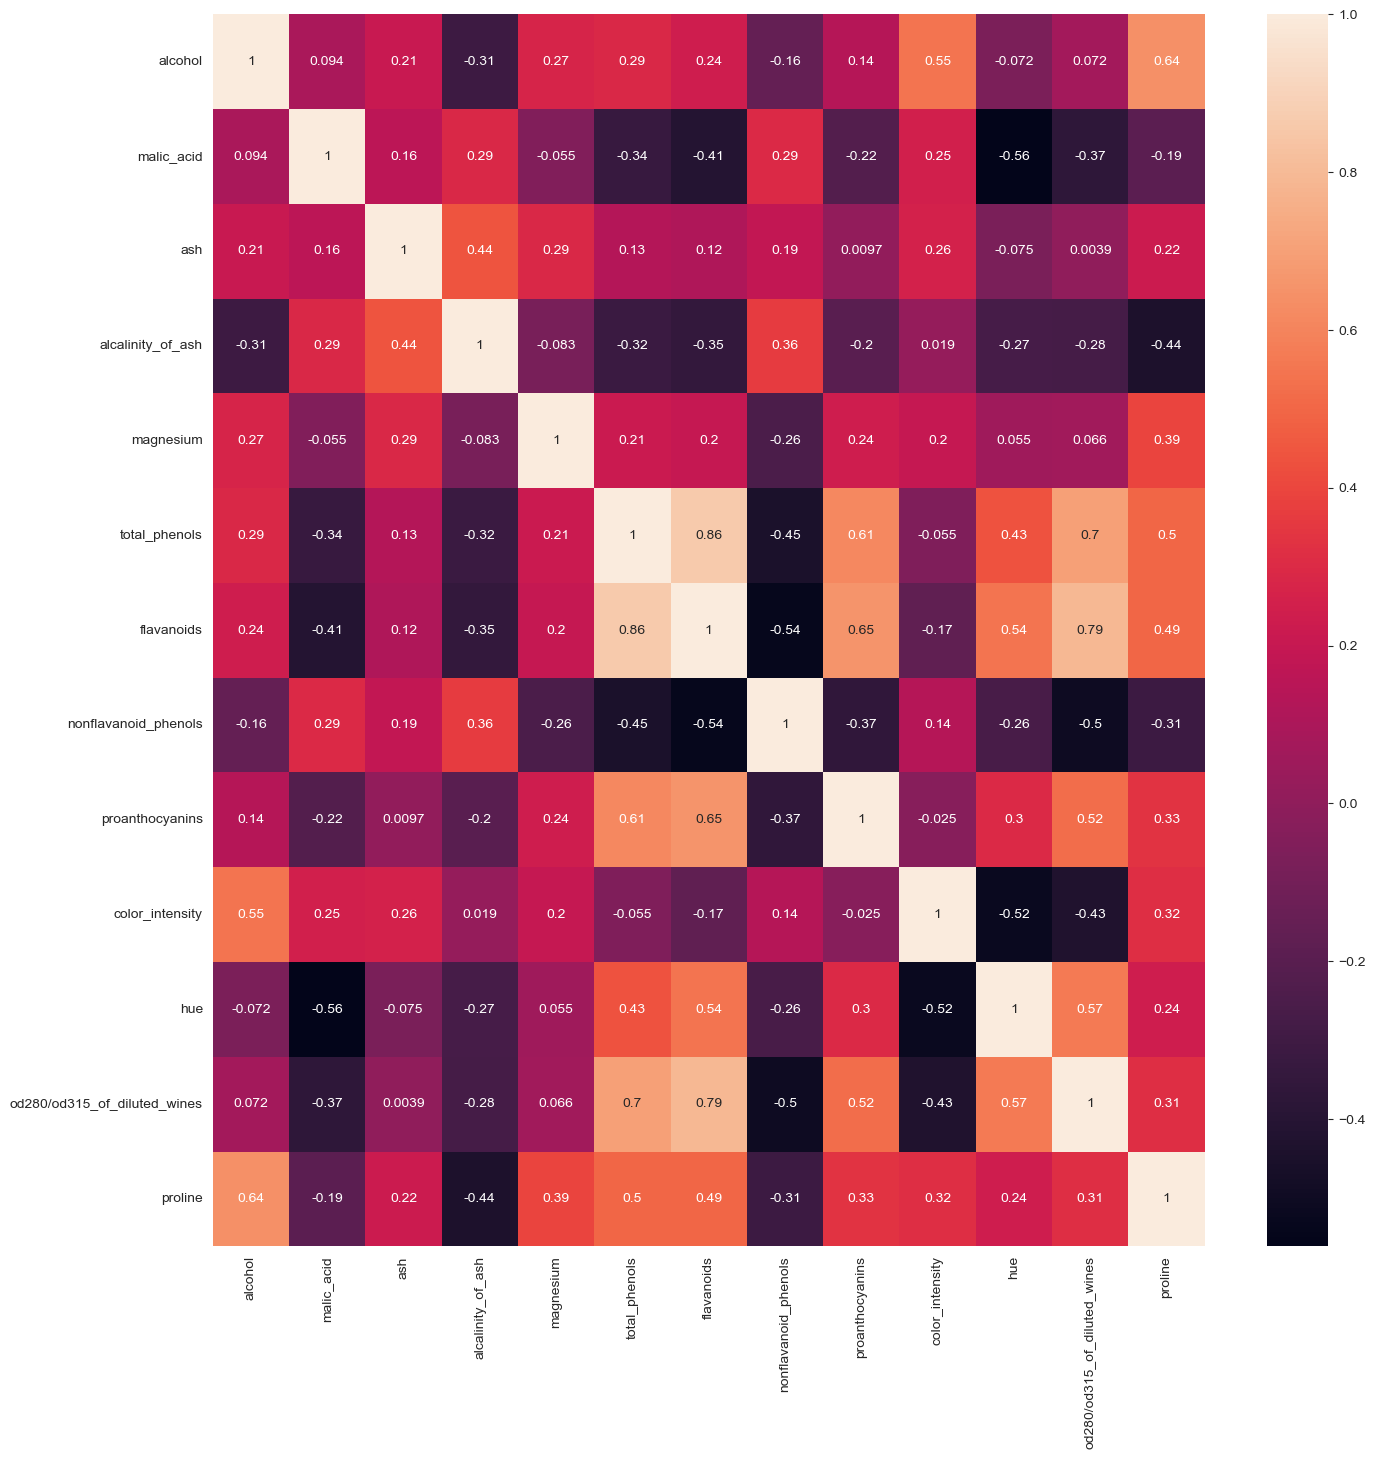

In [8]:
plt.figure(figsize = (16,16))
sns.heatmap(df.iloc[:,:-1].corr(), annot=True)
plt.show()

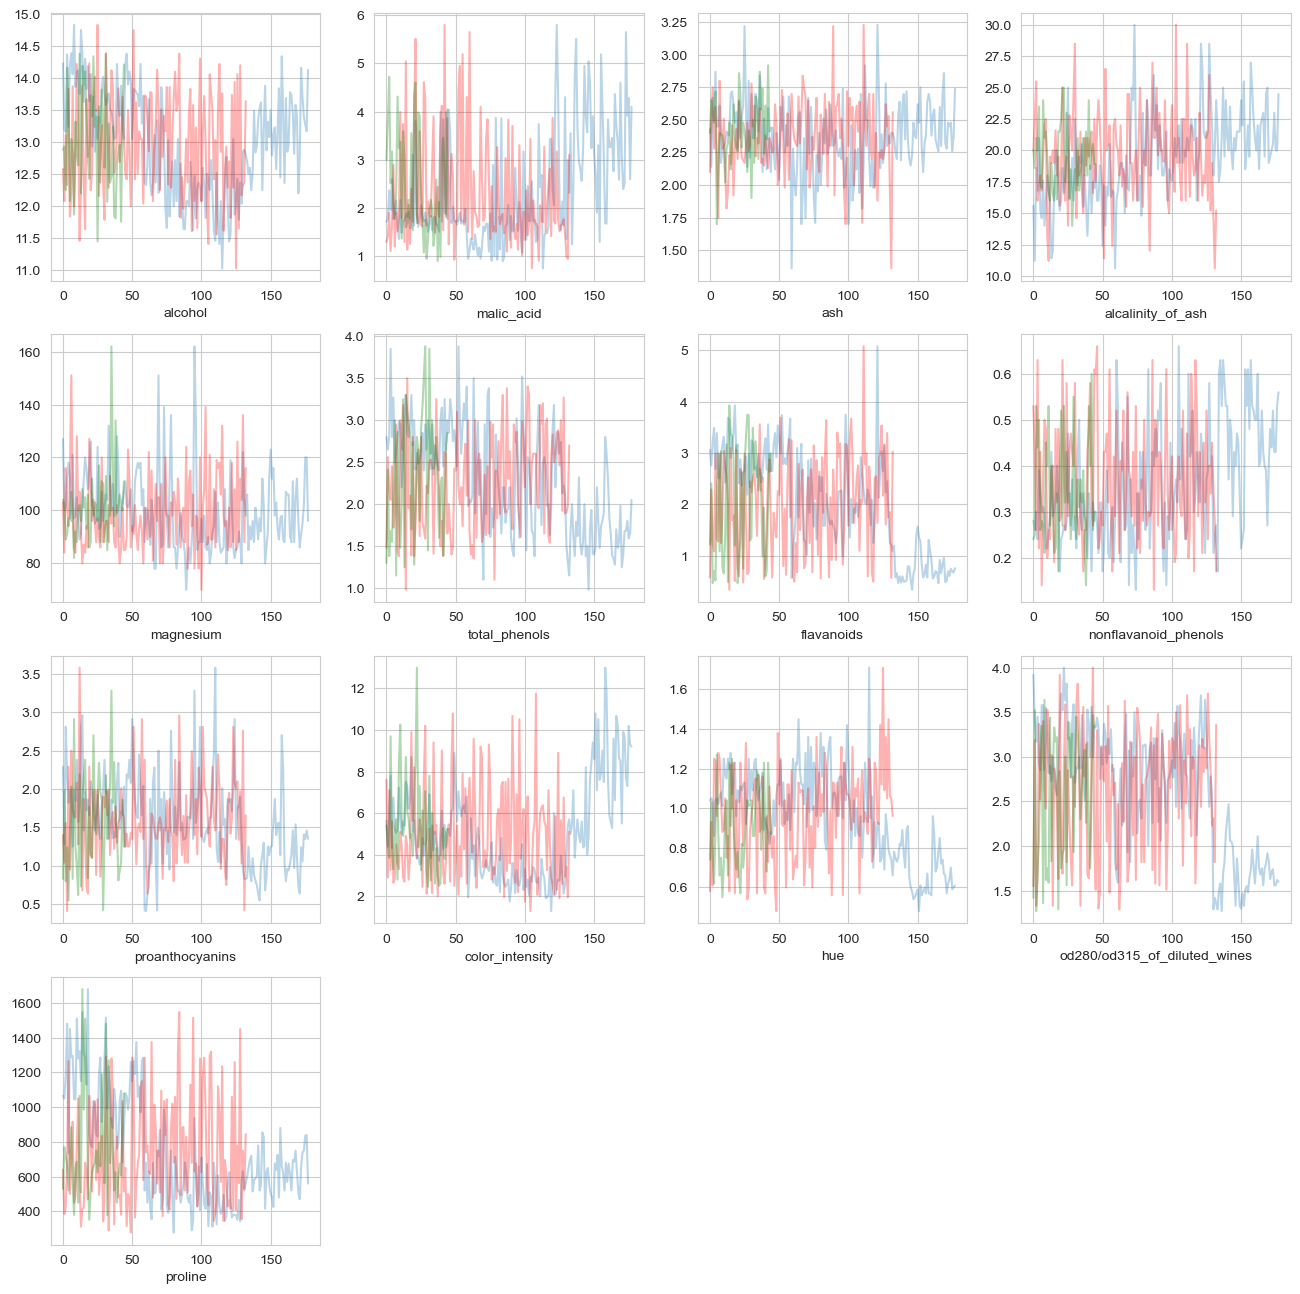

In [9]:
fig = plt.figure(figsize=(16, 16))
labels = wine.feature_names
for label in range(len(labels)):
    ax = fig.add_subplot(4,4,label+1)
    ax.plot(X[:, label], alpha = 0.3)
    ax.plot(X_train[:, label], color="red", alpha = 0.3)
    ax.plot(X_test[:, label], color="green", alpha = 0.3)
    ax.set_xlabel(labels[label])

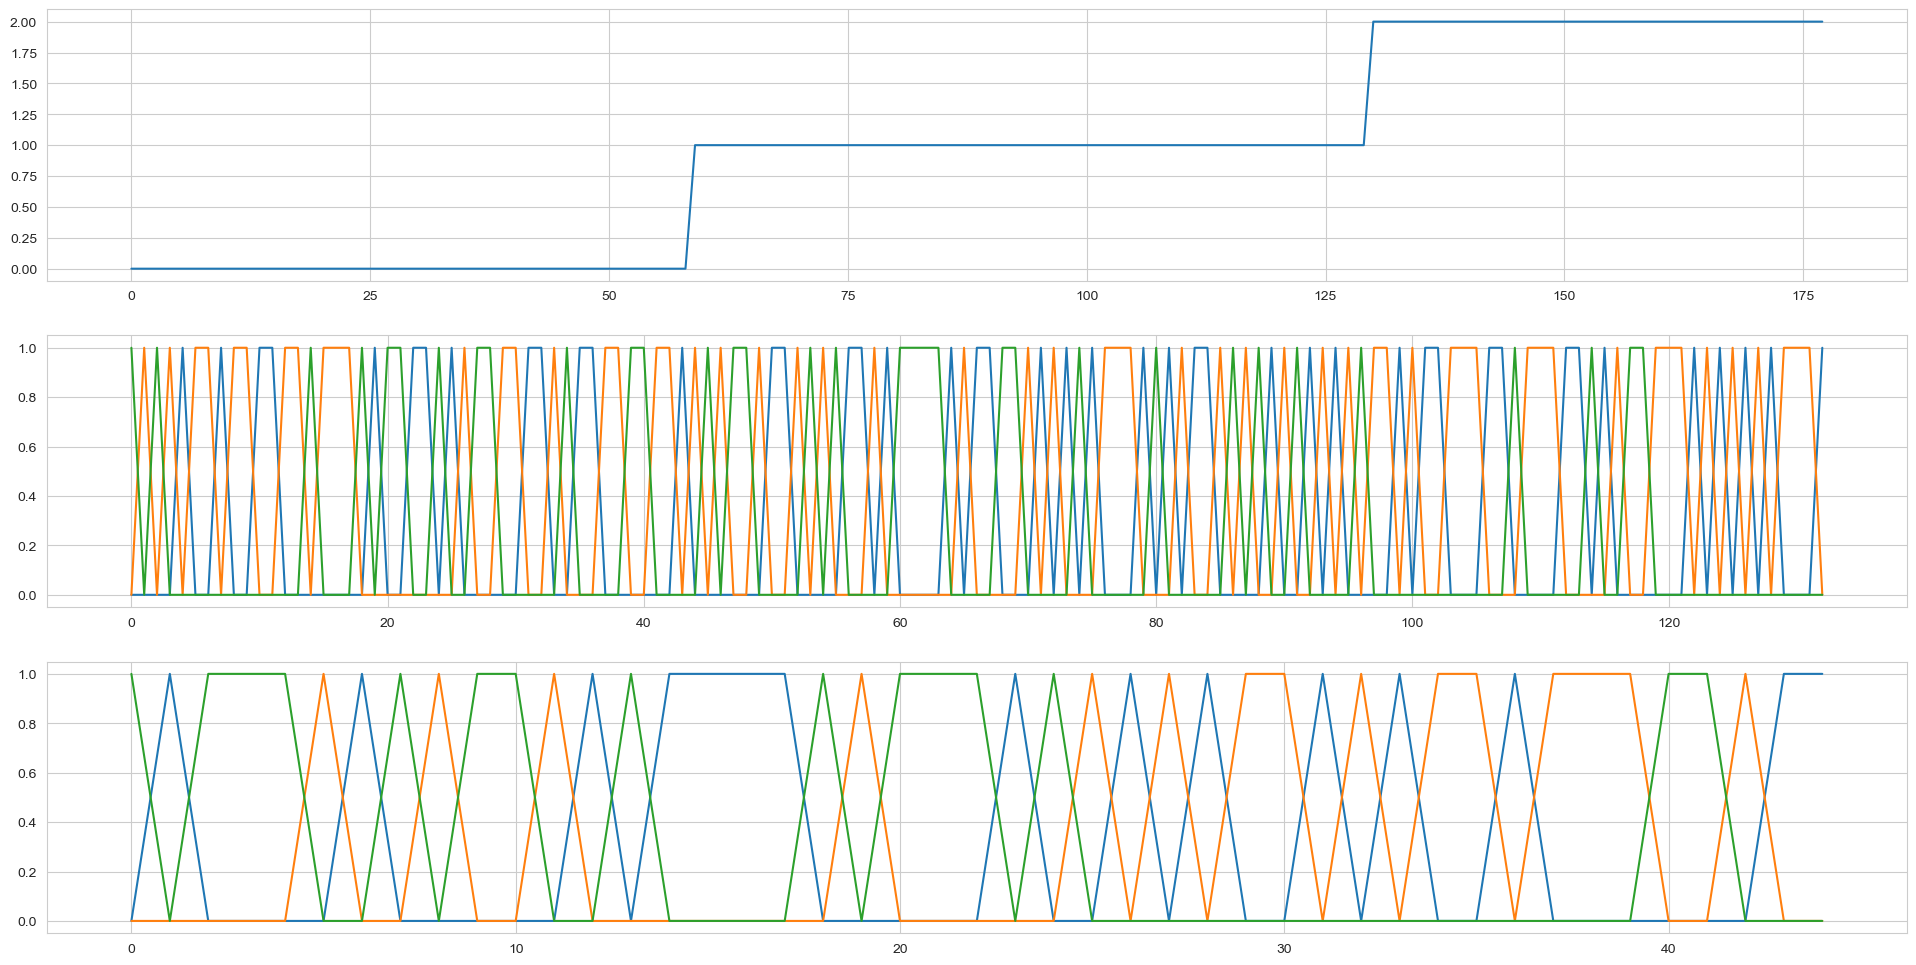

In [10]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(y)
ax2 = fig.add_subplot(3,1,2)
ax2.plot(y_train)
ax3 = fig.add_subplot(3,1,3)
ax3.plot(y_test)
plt.show()

In [11]:
folder_path = "logs/midterm"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'logs/midterm' has been deleted.


In [12]:
# define model builder for tuning
input_dim = len(X_train[0, :])
class_num = len(y_train[0, :]) 


# Only the hidden layer is tuned, and just its nodes
# We use rect. linear unified function for the hidden layer
# and then softmax for output because this is classification and we want that probability distribution
def model_builder(hp):
    # create model
    init = TruncatedNormal(stddev=0.01)
    adam = Adam(learning_rate=0.005)
    model = Sequential()
    # hidden layer
    hp_units = hp.Int("units", min_value = 5, max_value = 60, step = 5)
    model.add(Dense(units = hp_units, input_dim = input_dim, activation = "relu", kernel_initializer = init))
    ### add the final layer
    model.add(Dense(class_num, activation = "softmax", kernel_initializer = init))  
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [13]:
# create a Hyperband tuner for accuracy, with 100 epochs
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=100, factor=3, 
                     directory="logs/", project_name='midterm')

# set the callback for loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# set up a search on the training set, 100 epochs, splitting at 20% for validation
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=5)[0]
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units')}.""")

Trial 11 Complete [00h 00m 01s]
val_accuracy: 0.8148148059844971

Best val_accuracy So Far: 0.8518518805503845
Total elapsed time: 00h 00m 11s
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 30.


In [14]:
# Build the model with the optimal hyperparameters and train it on the data for 300 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), shuffle=False)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/300
5/5 [==============================] - 1s 38ms/step - loss: 1.0525 - accuracy: 0.3684 - val_loss: 1.0552 - val_accuracy: 0.3333
Epoch 2/300
5/5 [==============================] - 0s 8ms/step - loss: 0.9953 - accuracy: 0.5564 - val_loss: 0.9680 - val_accuracy: 0.4444
Epoch 3/300
5/5 [==============================] - 0s 7ms/step - loss: 0.9019 - accuracy: 0.5789 - val_loss: 0.8830 - val_accuracy: 0.5778
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 0.7703 - accuracy: 0.6992 - val_loss: 0.8342 - val_accuracy: 0.5333
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 0.7113 - accuracy: 0.6692 - val_loss: 0.7866 - val_accuracy: 0.5778
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6769 - accuracy: 0.6692 - val_loss: 0.8483 - val_accuracy: 0.5778
Epoch 7/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6319 - accuracy: 0.6917 - val_loss: 0.7540 - val_accuracy: 0.5778
Epoch 8/300
5/5 [=========

5/5 [==============================] - 0s 8ms/step - loss: 0.1061 - accuracy: 0.9624 - val_loss: 0.1724 - val_accuracy: 0.9333
Epoch 60/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1050 - accuracy: 0.9624 - val_loss: 0.1710 - val_accuracy: 0.9333
Epoch 61/300
5/5 [==============================] - 0s 7ms/step - loss: 0.1036 - accuracy: 0.9624 - val_loss: 0.1687 - val_accuracy: 0.9333
Epoch 62/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1026 - accuracy: 0.9624 - val_loss: 0.1684 - val_accuracy: 0.9333
Epoch 63/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1013 - accuracy: 0.9624 - val_loss: 0.1662 - val_accuracy: 0.9333
Epoch 64/300
5/5 [==============================] - 0s 7ms/step - loss: 0.1006 - accuracy: 0.9624 - val_loss: 0.1661 - val_accuracy: 0.9333
Epoch 65/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0993 - accuracy: 0.9624 - val_loss: 0.1630 - val_accuracy: 0.9333
Epoch 66/300
5/5 [===============

5/5 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.9774 - val_loss: 0.1389 - val_accuracy: 0.9556
Epoch 118/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0857 - accuracy: 0.9699 - val_loss: 0.1521 - val_accuracy: 0.9333
Epoch 119/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0768 - accuracy: 0.9699 - val_loss: 0.1278 - val_accuracy: 0.9333
Epoch 120/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.9624 - val_loss: 0.1387 - val_accuracy: 0.9333
Epoch 121/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0756 - accuracy: 0.9624 - val_loss: 0.1435 - val_accuracy: 0.9333
Epoch 122/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.9774 - val_loss: 0.1411 - val_accuracy: 0.9333
Epoch 123/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.9774 - val_loss: 0.1337 - val_accuracy: 0.9333
Epoch 124/300
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.0552 - accuracy: 0.9925 - val_loss: 0.1294 - val_accuracy: 0.9556
Epoch 176/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0546 - accuracy: 0.9925 - val_loss: 0.1292 - val_accuracy: 0.9556
Epoch 177/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.9925 - val_loss: 0.1286 - val_accuracy: 0.9333
Epoch 178/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.9925 - val_loss: 0.1309 - val_accuracy: 0.9333
Epoch 179/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0540 - accuracy: 0.9925 - val_loss: 0.1282 - val_accuracy: 0.9556
Epoch 180/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0537 - accuracy: 0.9925 - val_loss: 0.1283 - val_accuracy: 0.9333
Epoch 181/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9925 - val_loss: 0.1327 - val_accuracy: 0.9333
Epoch 182/300
5/5 [========

5/5 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.9925 - val_loss: 0.1270 - val_accuracy: 0.9333
Epoch 234/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.9925 - val_loss: 0.1249 - val_accuracy: 0.9333
Epoch 235/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0435 - accuracy: 0.9925 - val_loss: 0.1189 - val_accuracy: 0.9333
Epoch 236/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0444 - accuracy: 0.9925 - val_loss: 0.1279 - val_accuracy: 0.9333
Epoch 237/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9925 - val_loss: 0.1393 - val_accuracy: 0.9333
Epoch 238/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0456 - accuracy: 0.9925 - val_loss: 0.1118 - val_accuracy: 0.9556
Epoch 239/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9850 - val_loss: 0.1220 - val_accuracy: 0.9556
Epoch 240/300
5/5 [========

5/5 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9925 - val_loss: 0.1188 - val_accuracy: 0.9778
Epoch 292/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9925 - val_loss: 0.1188 - val_accuracy: 0.9778
Epoch 293/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0377 - accuracy: 0.9925 - val_loss: 0.1187 - val_accuracy: 0.9778
Epoch 294/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9925 - val_loss: 0.1187 - val_accuracy: 0.9778
Epoch 295/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9925 - val_loss: 0.1186 - val_accuracy: 0.9778
Epoch 296/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0373 - accuracy: 0.9925 - val_loss: 0.1186 - val_accuracy: 0.9778
Epoch 297/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9925 - val_loss: 0.1185 - val_accuracy: 0.9778
Epoch 298/300
5/5 [========

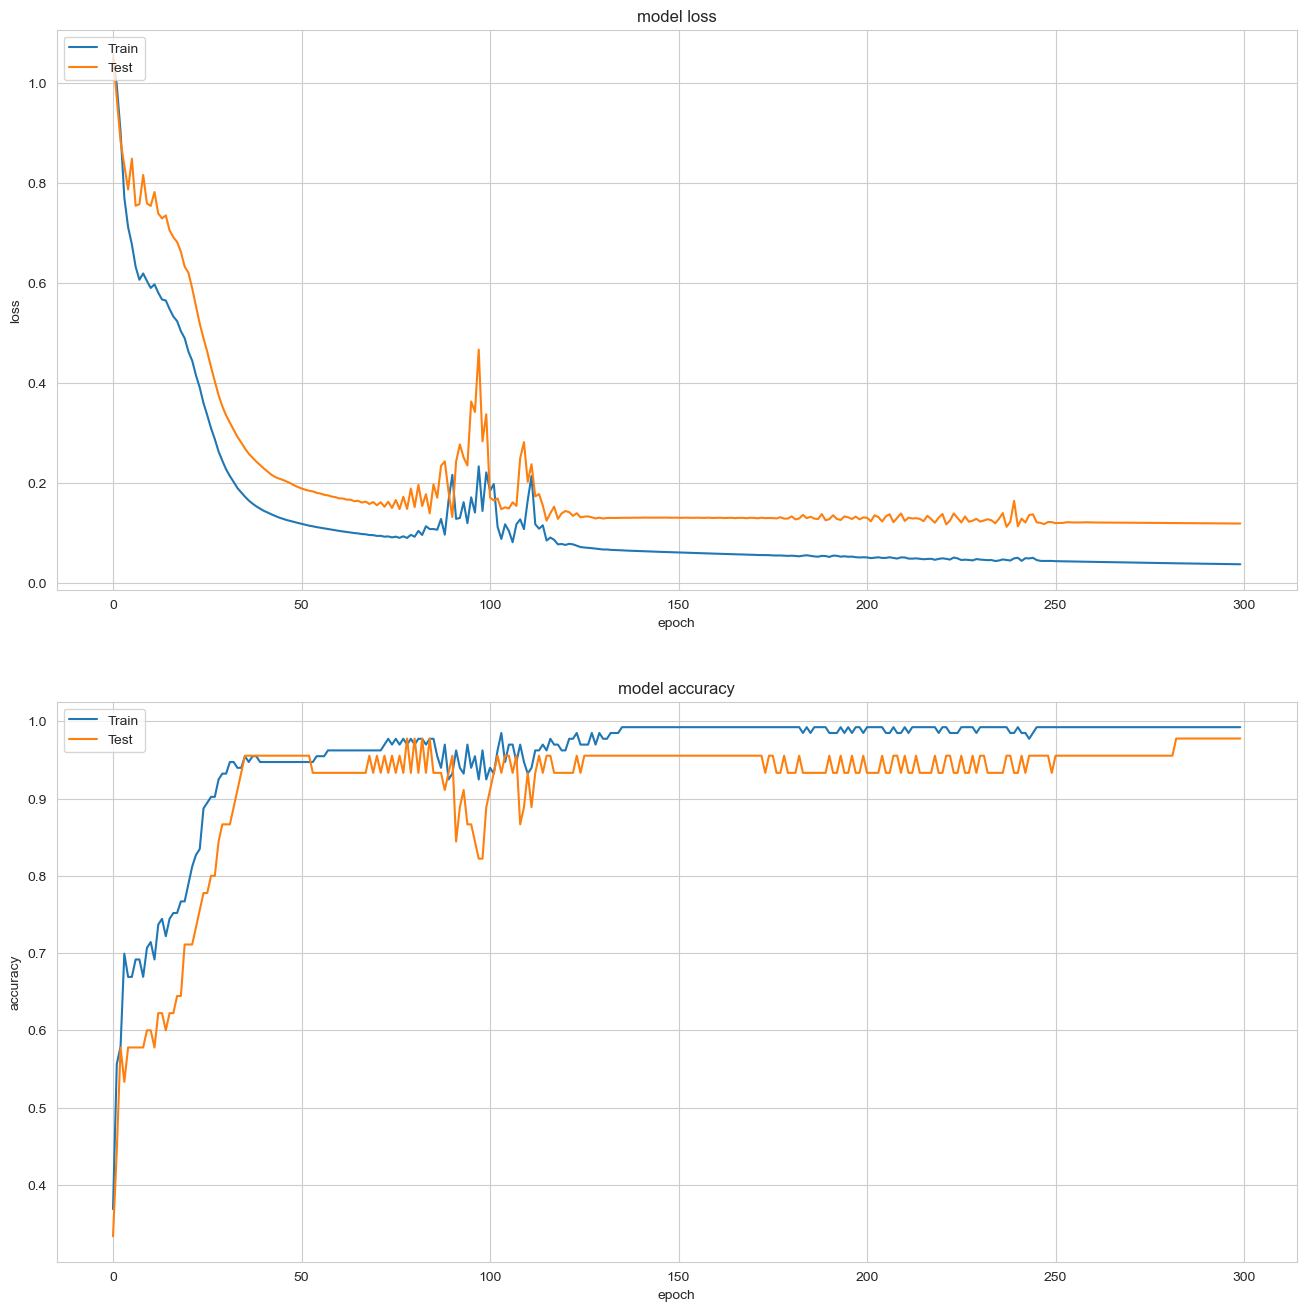

In [15]:
fig = plt.figure(figsize=(16, 16))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['Train', 'Test'], loc='upper left')
fig.show()

2/2 [==============================] - 0s 2ms/step
[[15  0  0]
 [ 0 14  1]
 [ 0  0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



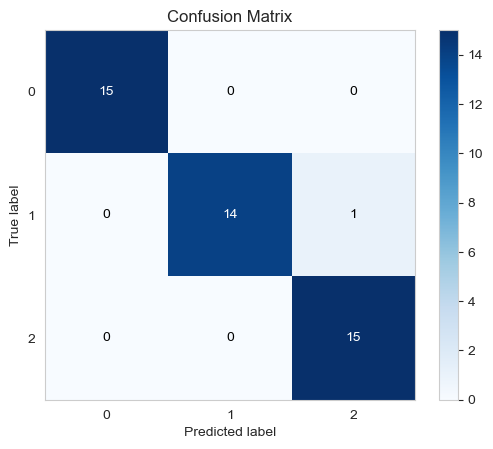

In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_am = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_am, y_pred))
print(classification_report(y_test_am, y_pred, labels=[0,1,2]))

plot_confusion_matrix(y_test_am, y_pred)
plt.show()

In [18]:
print("""The precision of the model seems to be pretty great, the recall is pretty solid, and the f1-score is quite solid overall. The accuracy is good as well. Overall, very few issues in the predictions on the test set, so this model is probably not overfit. The accuracy vs. val accuracy was around 99% vs. 97%, so that's better obviously but really not a huge difference. All in all, I think the model is well fit.""")

The precision of the model seems to be pretty great, the recall is pretty solid, and the f1-score is quite solid overall. The accuracy is good as well. Overall, very few issues in the predictions on the test set, so this model is probably not overfit. The accuracy vs. val accuracy was around 99% vs. 97%, so that's better obviously but really not a huge difference. All in all, I think the model is well fit.
